### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
### Prof. Francesco Rinaldi
---

In [1]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

# Data preparation

In [2]:
class DataProperties:
    n_samples = 200
    labeled_percentage = 0.04
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [3]:
from sklearn.datasets import make_blobs
import numpy as np

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)

In [4]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (200, 2), Y: (200,)


## Visualize fully labeled data

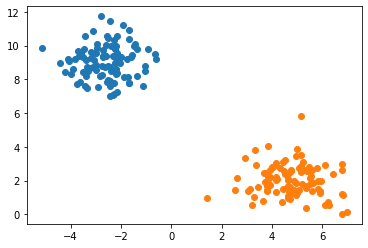

In [5]:
def plot_clusters(Y):
    fig, ax = plt.subplots()

    clusters = np.unique(Y)
    for c in clusters:
        mask = Y == c
        subset = X[mask]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            marker = 'o'
        )


plot_clusters(Y)

## Unlabel subset and visualize

In [6]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [7]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

assert(
    len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]) == int(len(Y) * (1 - DataProperties.labeled_percentage))
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 100 instances of object 0.0
We have to delabel 96 instances
Found 100 instances of object 1.0
We have to delabel 96 instances

    We have 192 unlabeled data
    Out of 200
    


## Visualize data after delabelling

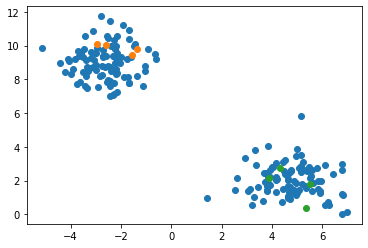

In [8]:
plot_clusters(Y_delabeled)

# Gradient Descent method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [9]:
import collections
collections.Counter(Y_delabeled)

Counter({-1000000.0: 192, 1.0: 4, 0.0: 4})

In [10]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

class GradientSolver:
    def __init__(
        self, 
        lr_strategy, 
        learning_rate, 
        similarity_func, 
        bcgd_strategy = None
    ):
        self.lr_strategy = lr_strategy
        self.learning_rate = learning_rate
        self.similarity_func = similarity_func

        self.losses = []

        
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):

        grad = []
        for unlabeled_idx in unlabeled_idxs:
            # compute component of gradient for this 
            # current unlabeled
            grad_component = 0.0
            
            for labeled_idx in labeled_idxs:
                w_ij = np.linalg.norm(X[unlabeled_idx] - X[labeled_idx])
                grad_component += 2 * w_ij * (Y[unlabeled_idx] - Y[labeled_idx])  # ???

            for another_unlab_idx in unlabeled_idxs:
                w_ij_ = np.linalg.norm(X[unlabeled_idx] - X[another_unlab_idx])
                grad_component += 2 * w_ij_ * (Y[unlabeled_idx] - Y[another_unlab_idx])
            
            grad.append(grad_component)

        return np.array(grad)

    def compute_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        res = 0
        for labeled_idx in labeled_idxs:
            for unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
                res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
        
        for unlab_idx in unlabeled_idxs:
            for another_unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
                res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
        
        return res

In [11]:
class GradientDescentSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, X, Y, iters_limit, delta_loss_limit):

        labeled_idxs = np.where(Y != DataProperties.unlabeled)[0]
        unlabeled_idxs = np.where(Y == DataProperties.unlabeled)[0]

        Y_res = np.ndarray.copy(Y)
        
        # fix initial approximation
        Y_res[Y_res == DataProperties.unlabeled] = 0.5

        loss_prev = 0.0
        self.losses = []
        for i in range(iters_limit):
            loss = self.compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            print(f'Loss: {loss}, delta loss: {delta_loss}')


            if (i > 0 and delta_loss < delta_loss_limit):
                return Y_res
            else:
                grad = self.compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)

                if self.lr_strategy == 'lr_constant':
                    updates = -self.learning_rate * grad
                # print(f'Max update: {np.max(updates)}')

                assert len(unlabeled_idxs) == len(grad)
                for i in range(len(grad)):
                    Y_res[unlabeled_idxs[i]] += updates[i]
                
                loss_prev = loss

        return Y_res

In [12]:
solver = GradientDescentSolver(
    similarity_func = euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00014
)

In [13]:
Y_preds = solver.solve(
    X,
    Y_delabeled,
    iters_limit = 50,
    delta_loss_limit = 0.007
)

Loss: 2312.110668607197, delta loss: 2312.110668607197
Loss: 2287.767859586376, delta loss: 24.342809020821278
Loss: 2283.3010725823183, delta loss: 4.466787004057551
Loss: 2282.4505692552175, delta loss: 0.850503327100796
Loss: 2282.2767816063383, delta loss: 0.17378764887916986
Loss: 2282.236710193253, delta loss: 0.04007141308511564
Loss: 2282.2257177320407, delta loss: 0.01099246121248143
Loss: 2282.222016349605, delta loss: 0.003701382435792766


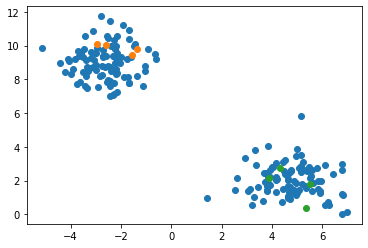

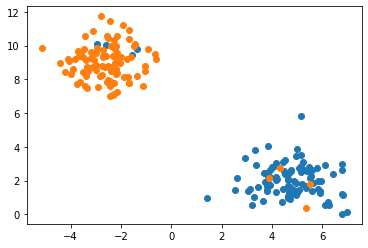

In [14]:
plot_clusters(Y_delabeled)

Y_preds[Y_preds < 0.5] = 0.0
Y_preds[Y_preds >= 0.5] = 1.0
plot_clusters(Y_preds)

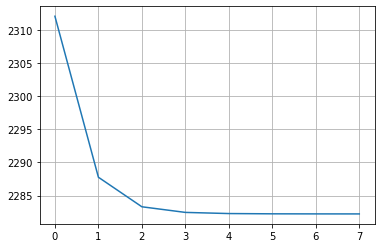

In [15]:
plt.plot(solver.losses)
plt.grid()

# Block coordinates gradient descent (randomized)